In [7]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot
from simulations.analysis.plotting_helpers import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
df_ps_dict = load_data(["bb", "bb_gapproxy"])

## pfail vs pabort

In [3]:
from plotting_helpers import take_best_by_from_df_ps_dict

df_ps_best = take_best_by_from_df_ps_dict(
    df_ps_dict,
    exclude=(lambda by: by in {"pred_llr", "detector_density"}),
    use_pfail_upper=False,
)

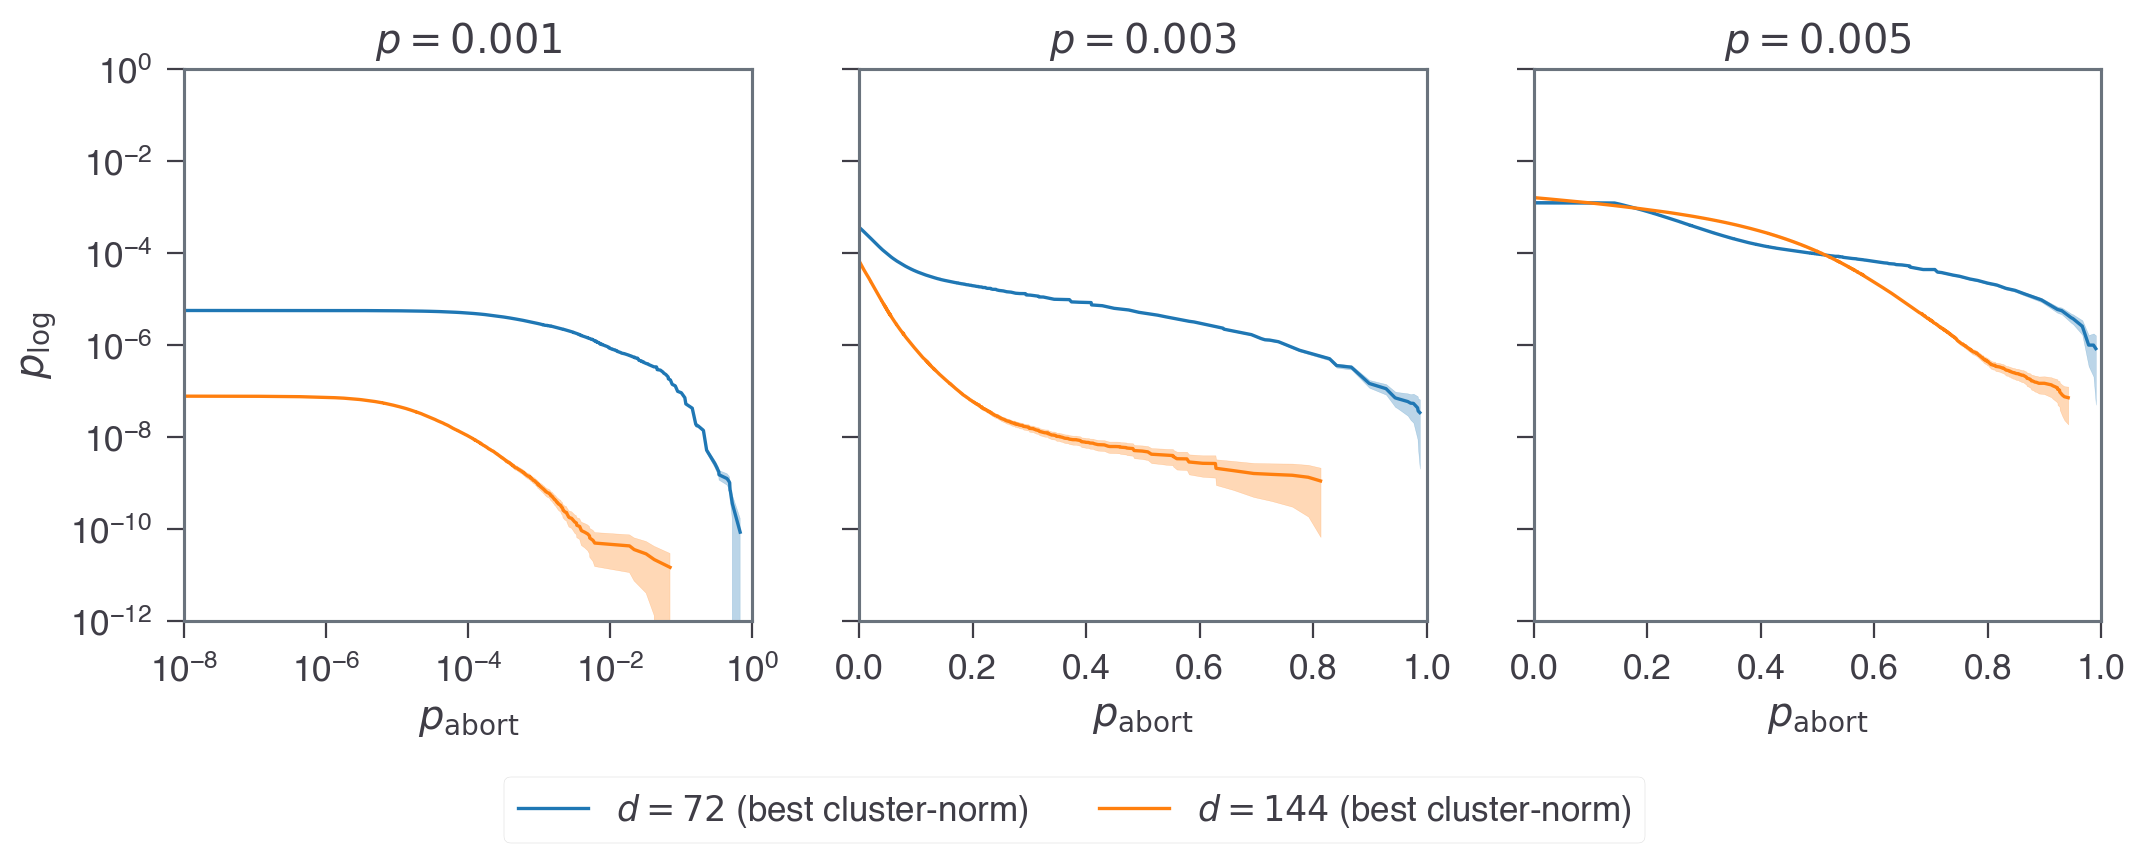

In [4]:
from plotting_helpers import (
    get_lower_envelope,
    error_band_plot,
)

fig, axes = plt.subplots(1, 3, figsize=(DFT_FIG_WIDTH_WIDE, 4), sharey=True)

p_values = [0.001, 0.003, 0.005]

nlist = df_ps_best.index.get_level_values("n").unique()

# Create legend handles and labels
legend_handles = []
legend_labels = []

for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_n, n in enumerate(nlist):
        T = {144: 12, 72: 6}[n]
        df_ps_d = df_ps_best.loc[idx[n, T, p, :], :]
        p_abort = df_ps_d.index.get_level_values("p_abort").values
        p_fail = df_ps_d["p_fail"].values / n
        delta_p_fail = df_ps_d["delta_p_fail"].values / n
        line1 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=COLORS(i_n),
            label=rf"$d={n}$ (best cluster-norm)",
            ax=ax,
        )

        # Collect legend handles and labels only from the first subplot
        if i_p == 0:
            legend_handles.append(line1[0])
            legend_labels.append(rf"$d={n}$ (best cluster-norm)")

    if i_p == 0:
        ax.set_xscale("log")
        ax.set_xlim(1e-8, 1)
    else:
        ax.set_xlim(0, 1)
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1)
    ax.set_xlabel(r"$p_\mathrm{abort}$")
    ax.set_title(f"$p = {p}$")

    if i_p == 0:
        ax.set_ylabel(r"$p_\mathrm{log}$")

# Add legend below the figure with 3 columns
fig.legend(
    legend_handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)

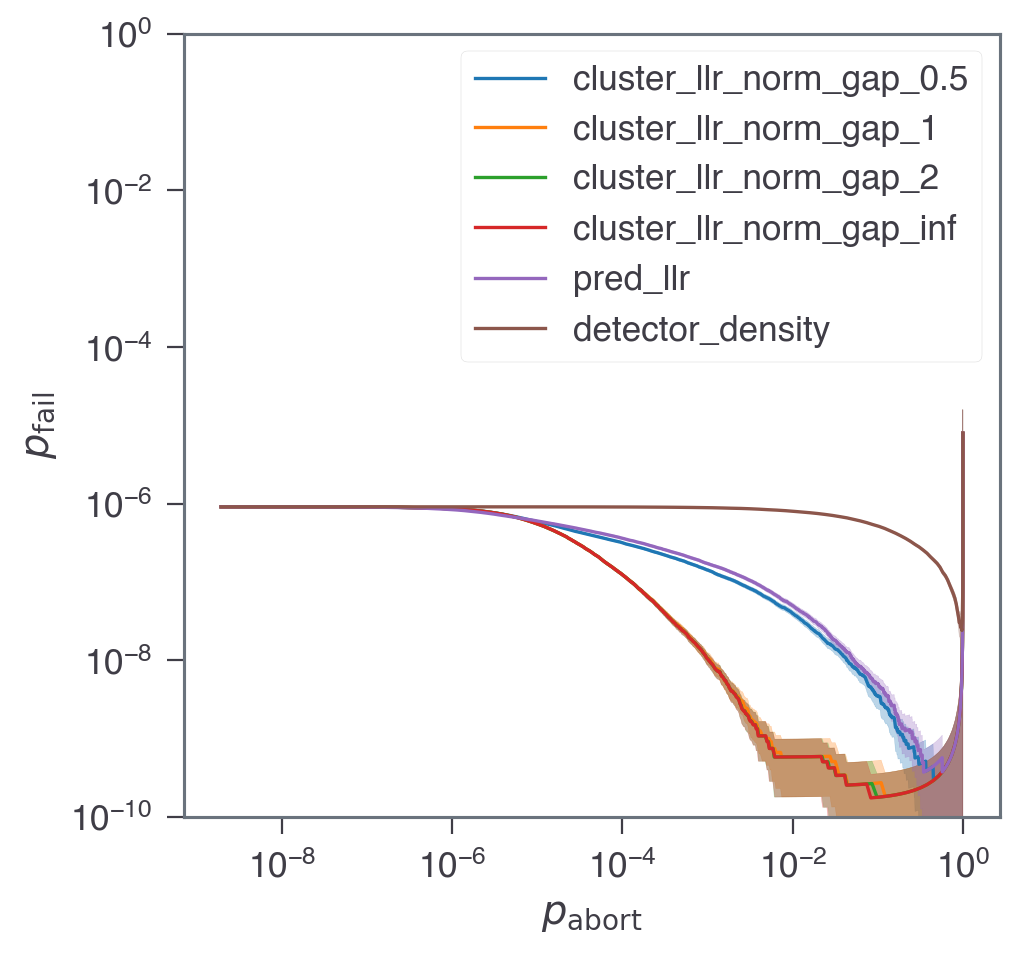

In [54]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

n = 144
T = {144: 12, 72: 6}[n]
p = 0.001


# Create ordered list of keys
ordered_keys = []

# First, add cluster_llr_norm_gap keys in ascending order of i (as float)
cluster_keys = [key for key in df_ps_dict.keys() if "cluster_llr_norm_gap" in key]
# Sort by extracting the number after 'cluster_llr_norm_gap_' as float
cluster_keys.sort(
    key=lambda x: (
        float(x.split("_")[-1])
        if x.split("_")[-1].replace(".", "").isdigit()
        else float("inf")
    )
)
ordered_keys.extend(cluster_keys)

# Then add the other keys in specified order
for key in ["pred_llr", "detector_density"]:
    if key in df_ps_dict:
        ordered_keys.append(key)

i = 0
data_plots = {}
for by in ordered_keys:
    df_ps = df_ps_dict[by].loc[(n, T, p)]

    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

ax.set_xscale("log")
# ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

0: cluster_llr_norm_gap_inf (2.72e-04 ± 4.66e-06)
1: cluster_llr_norm_gap_2 (2.83e-04 ± 4.74e-06)
2: cluster_llr_norm_1 (2.84e-04 ± 4.75e-06)
3: cluster_llr_norm_gap_1 (2.84e-04 ± 4.75e-06)
4: cluster_llr_norm_2 (2.88e-04 ± 4.79e-06)
5: cluster_llr_norm_inf (3.08e-04 ± 4.95e-06)
6: cluster_llr_residual_sum_gap (3.27e-04 ± 5.10e-06)
7: cluster_llr_residual_sum (3.92e-04 ± 5.58e-06)
8: pred_llr (4.35e-04 ± 5.88e-06)
9: detector_density (9.11e-03 ± 2.51e-05)
10: cluster_llr_norm_gap_0.5 (1.02e-02 ± 2.67e-05)
11: cluster_llr_norm_0.5 (2.01e-02 ± 3.49e-05)


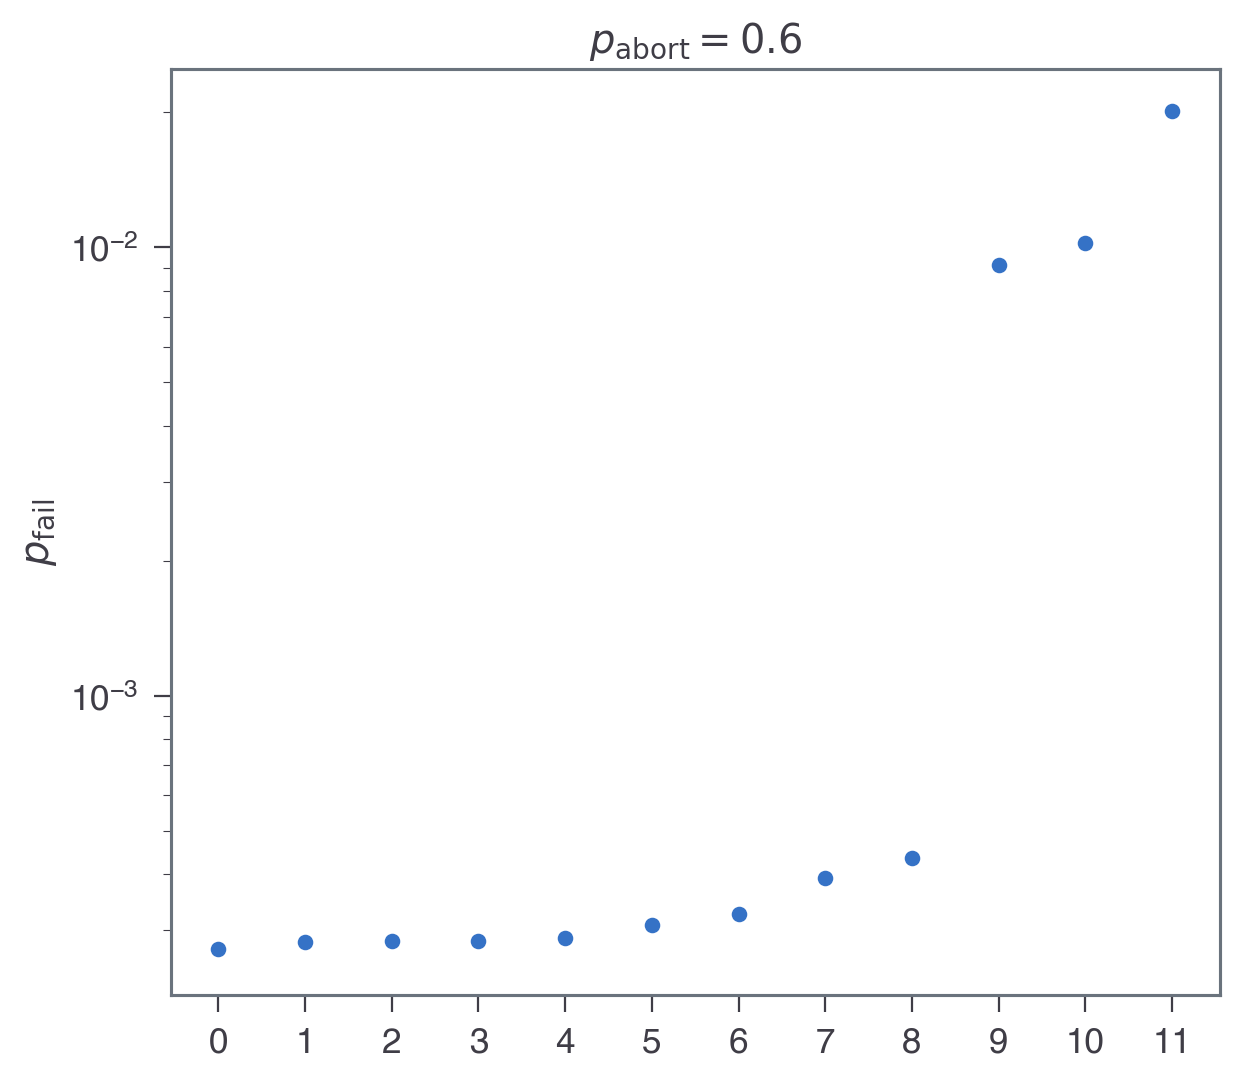

In [21]:
target = 0.6
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()

## Cluster statstics

In [20]:
df_agg_dict = load_data("bb", "agg")

<Axes: xlabel='cluster_llr_norm_gap', ylabel='Density'>

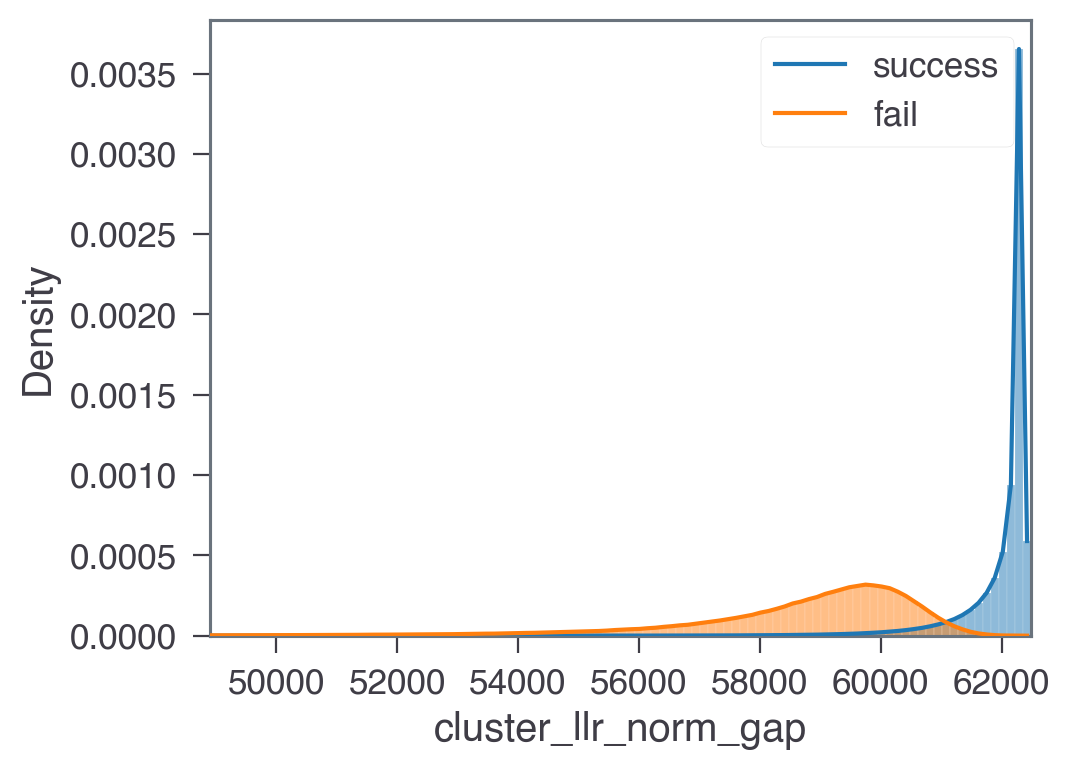

In [52]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import plot_success_failure_histogram

by = "cluster_llr_norm_gap_2"
# by = "matching_gap"
# by = "pred_llr"
n = 144
d = {72: 6, 144: 12}[n]
p = 3e-3

df_agg = df_agg_dict[by].loc[(n, d, p)]

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

plot_success_failure_histogram(
    df_agg,
    bins=500,
    colors=[COLORS(0), COLORS(1)],
    # rescale_by_rate=True,
    # twin_y=True,
    alpha=0.5,
    ax=ax,
    lower_trim_frac=1e-2,
)